# Data exploration of Wine dataset
### **Dataset Overview**
This dataset, sourced from Hugging Face (`alfredodeza/wine-ratings`), contains information about various wines, including their names, regions, varieties, ratings, and tasting notes. The dataset is structured as follows:

- **name**: The name of the wine.
- **region**: The region where the wine is produced.
- **variety**: The type or variety of the wine (e.g., Red Wine, Chardonnay).
- **rating**: The rating of the wine, typically on a scale of 0 to 100.
- **notes**: Tasting notes or descriptions of the wine.

#### **Example Rows**
| name                                              | region                  | variety   | rating | notes                                                                 |
|---------------------------------------------------|-------------------------|-----------|--------|-----------------------------------------------------------------------|
| 1000 Stories Bourbon Barrel Aged Batch Blue Ca... | Mendocino, California   | Red Wine  | 91.0   | This is a very special, limited release of 100...                     |
| 1000 Stories Bourbon Barrel Aged Gold Rush Red... | California              | Red Wine  | 89.0   | The California Gold Rush was a period of coura...                     |
| 1000 Stories Bourbon Barrel Aged Zinfandel 2013   | North Coast, California | Red Wine  | 91.0   | The wine has a deep, rich purple color. An int...                     |

---

### **Goals of the Analysis**
The primary goals of this exploratory data analysis (EDA) are:
1. **Understand the Distribution of Wine Ratings**:
   - What is the average rating of wines in the dataset?
   - Are there any outliers or unusual patterns in the ratings?

2. **Explore Wine Varieties and Regions**:
   - Which wine varieties and regions are most common?
   - Are certain regions or varieties associated with higher ratings?

3. **Analyze Tasting Notes**:
   - What are the most common words or phrases used in wine descriptions?
   - Are there emerging trends in wine descriptions (e.g., sustainability, organic practices)?

4. **Identify Trends Over Time**:
   - How has the popularity of certain varieties or regions changed over time?
   - Are there any noticeable trends in wine ratings or descriptions over the years?

5. **Build Insights for Recommendations**:
   - Can we recommend wines based on similar tasting notes or regions?
   - What factors contribute to high-rated wines?

---

### **Key Questions to Answer**
1. **What are the most common wine varieties and regions?**
2. **How are wine ratings distributed? Are there any patterns?**
3. **What are the most frequent words in wine tasting notes?**
4. **Are there correlations between regions, varieties, and ratings?**
5. **How have wine trends (e.g., varieties, descriptions) evolved over time?**

### **1. Imports**
This section includes all the necessary libraries and tools for the analysis

In [3]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
%matplotlib inline
import warnings
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### **2. Environment Setup**
This section sets up the environment for accessing the Hugging Face dataset:
- **Load Environment Variables**: Use `dotenv` to load the Hugging Face API token from a `.env` file.
- **Hugging Face Login**: Log in to Hugging Face Hub using the API token.

In [4]:
# environment

load_dotenv()
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### **3. Loading the Dataset**
This section loads the wine ratings dataset from Hugging Face:
- **Dataset Source**: The dataset is loaded using the `load_dataset` function from the `datasets` library.
- **Dataset Splits**: The dataset is divided into `train`, `validation`, and `test` splits.
- **Combine Data**: All splits are combined into a single DataFrame for analysis.

In [5]:
# Load dataset
dataset = load_dataset("alfredodeza/wine-ratings")

# Convert splits to pandas DataFrames
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

# Combine all splits into one DataFrame
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [8]:
full_df.head()

name                   region  \
0  1000 Stories Bourbon Barrel Aged Batch Blue Ca...    Mendocino, California   
1  1000 Stories Bourbon Barrel Aged Gold Rush Red...               California   
2  1000 Stories Bourbon Barrel Aged Gold Rush Red...               California   
3    1000 Stories Bourbon Barrel Aged Zinfandel 2013  North Coast, California   
4    1000 Stories Bourbon Barrel Aged Zinfandel 2014               California   

    variety  rating                                              notes  
0  Red Wine    91.0  This is a very special, limited release of 100...  
1  Red Wine    89.0  The California Gold Rush was a period of coura...  
2  Red Wine    90.0  The California Gold Rush was a period of coura...  
3  Red Wine    91.0  The wine has a deep, rich purple color. An int...  
4  Red Wine    90.0  Batch #004 is the first release of the 2014 vi...

### **4. Checking for Missing Values**
This section checks for missing values in the dataset:
- **Purpose**: Identify columns with missing data that may need to be cleaned or imputed.
- **Output**: A summary of missing values for each column.

In [5]:
# Check for missing values
print("\nMissing values:")
print(full_df.isnull().sum())


Missing values:
name         0
region       3
variety    361
rating       0
notes        0
dtype: int64


### **5. Distribution of Missing Values by Features**
This bar chart shows the number of missing values for each feature in the dataset.

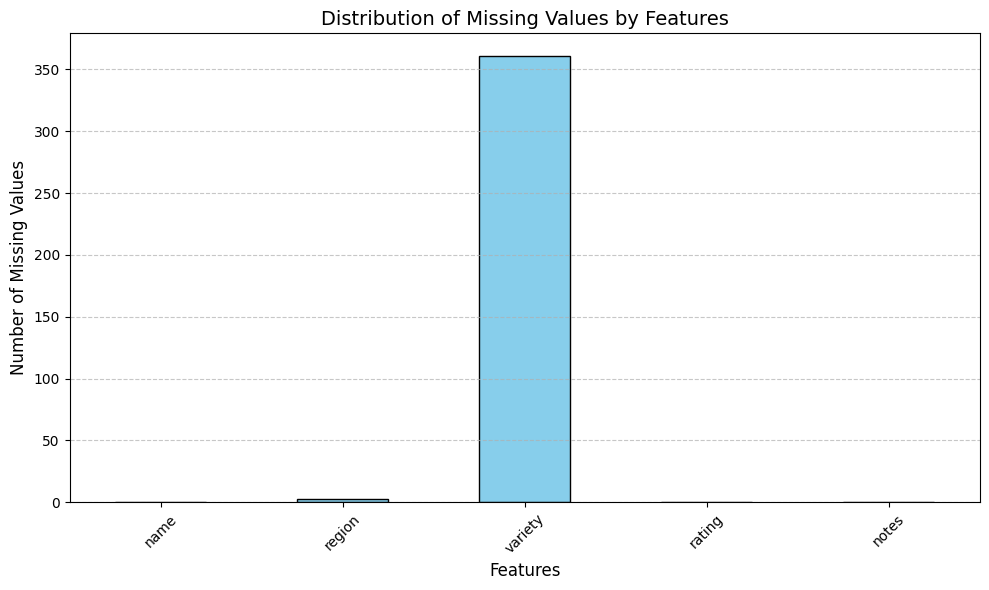

In [6]:
plt.figure(figsize=(10, 6))
full_df.isnull().sum().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Missing Values by Features", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Number of Missing Values", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **Insights**
- **`region`**: Most missing values.
- **`notes`**: Significant missing values.
- **`variety`**: Fewer missing values.
- **`name` and `rating`**: No missing values.

### **6.Predicting Missing Wine Varieties Using RandomForestClassifier**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
# Assume full_df is your combined dataset
# Split the data into two parts: where 'variety' is known and where it is missing
known_data = full_df[full_df['variety'].notnull()]  # Rows with known 'variety'
unknown_data = full_df[full_df['variety'].isnull()]  # Rows with missing 'variety'

In [9]:
# Define features (X) and target variable (y)
X = known_data[['region', 'notes', 'rating']]  # Features: region, notes, rating
y = known_data['variety']  # Target: variety

# Encode categorical variables (region, notes) and keep numerical variables (rating) as is
categorical_features = ['region', 'notes']  # Categorical columns
numerical_features = ['rating']  # Numerical column

# Create a preprocessor to handle categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # One-hot encode categorical features
        ('num', 'passthrough', numerical_features)  # Pass numerical features as is
    ])

# Create a pipeline: preprocess data and then apply a RandomForestClassifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess the data
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Use RandomForest for classification
])

# Split the known data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region', 'notes']),
                                                 ('num', 'passthrough',
                                                  ['rating'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [10]:
# Evaluate the model on the test data
y_pred = model.predict(X_test)
print(f"Model accuracy: {accuracy_score(y_test, y_pred):.2f}")  # Print model accuracy

# Predict missing 'variety' values for the unknown data
unknown_data['variety'] = model.predict(unknown_data[['region', 'notes', 'rating']])

# Combine the known and predicted data
full_df_filled = pd.concat([known_data, unknown_data], ignore_index=True)

# Check if all missing values are filled
print("\nMissing values after filling:")
print(full_df_filled.isnull().sum())  # Print the count of missing values in each column

Model accuracy: 0.84

Missing values after filling:
name       0
region     3
variety    0
rating     0
notes      0
dtype: int64


### **Summary of Output**
- **Model Accuracy**: 84% (strong performance in predicting `variety`).
- **Missing Values**:
  - All `variety` values filled.
  - 3 missing values remain in `region`.
- **Final Dataset**: Mostly complete and ready for analysis.

### **Drop Missing Values**

In [11]:
wine_df = full_df_filled.dropna()
print("The shape of data before drop missing values:")
print(full_df_filled.shape)
print("The shape of data after drop missing values:")
print(wine_df.shape)

The shape of data before drop missing values:
(33180, 5)
The shape of data after drop missing values:
(33177, 5)


### **7. Visualize the Distribution of Wine Ratings to understand how wine ratings are distributed across the dataset**

In [12]:
# Create a histogram of the 'rating' column
alt.data_transformers.enable("vegafusion")
chart = alt.Chart(wine_df).mark_bar().encode(
    x=alt.X('rating:Q', bin=alt.Bin(maxbins=30), title='Rating'),  # Bin the ratings into 30 bins
    y=alt.Y('count()', title='Number of Wines'),  # Count the number of wines in each bin
    tooltip=['count()']  # Add tooltips to show the count on hover
).properties(
    title='Distribution of Wine Ratings'  # Add a title to the chart
)

# Display the chart
chart.show()

alt.Chart(...)

In [13]:
print(f"The min rating in dataset is: {wine_df.rating.min()}")
print(f"The max rating in dataset is: {wine_df.rating.max()}")

The min rating in dataset is: 85.0
The max rating in dataset is: 99.0


### **Key Insights**
1. **Rating Distribution**:
   - Most wines have ratings between **85 and 95**, indicating a concentration of high-quality wines.
2. **Shape of Distribution**:
   - The distribution is slightly **left-skewed**, meaning there are more wines with higher ratings than lower ratings.
3. **Tooltips**:
   - Hovering over the bars shows the exact count of wines in each rating bin.

### **8. Distribution of Wine Ratings by Rate Category**
In this section, we analyze the distribution of wine ratings, categorized into different rate categories: **low**, **middle**, and **high**. This categorization helps us understand how wines are distributed across different quality levels.


In [14]:
# Define the bin edges and labels
bin_edges = [0, 85, 88, 93, 100]  # Extended bin edges to cover all possible ratings
bin_labels = ['very low', 'low', 'middle', 'high']

# Bin the 'rating' column and create a new categorical column
wine_df['rate_category'] = pd.cut(wine_df['rating'], bins=bin_edges, labels=bin_labels, right=False)
wine_df.head()

name                   region  \
0  1000 Stories Bourbon Barrel Aged Batch Blue Ca...    Mendocino, California   
1  1000 Stories Bourbon Barrel Aged Gold Rush Red...               California   
2  1000 Stories Bourbon Barrel Aged Gold Rush Red...               California   
3    1000 Stories Bourbon Barrel Aged Zinfandel 2013  North Coast, California   
4    1000 Stories Bourbon Barrel Aged Zinfandel 2014               California   

    variety  rating                                              notes  \
0  Red Wine    91.0  This is a very special, limited release of 100...   
1  Red Wine    89.0  The California Gold Rush was a period of coura...   
2  Red Wine    90.0  The California Gold Rush was a period of coura...   
3  Red Wine    91.0  The wine has a deep, rich purple color. An int...   
4  Red Wine    90.0  Batch #004 is the first release of the 2014 vi...   

  rate_category  
0        middle  
1        middle  
2        middle  
3        middle  
4        middle

In [15]:
chart = alt.Chart(wine_df).mark_bar().encode(
    x=alt.X('rating:Q', bin=alt.Bin(maxbins=30), title='Rating'),  # Bin the ratings into 30 bins
    y=alt.Y('count()', title='Number of Wines'),  # Count the number of wines in each bin
    color=alt.Color('rate_category:N', scale=alt.Scale(domain=['low', 'middle', 'high'],
                                                      range=['#1f77b4', '#ff7f0e', '#2ca02c']),
                   legend=alt.Legend(title='Rate Category')),  # Color by rate_category
    tooltip=['count()']  # Add tooltips to show the count on hover
).properties(
    title='Distribution of Wine Ratings by Rate Category'  # Add a title to the chart
)

# Display the chart
chart.show()

alt.Chart(...)

### **Summary of Insights**
1. **Rating Distribution**:
   - Most wines fall into the **middle** and **high** categories, indicating a concentration of good to excellent quality wines.
   - Fewer wines are in the **low** category, suggesting that the dataset is skewed toward higher-quality wines.
2. **Rate Categories**:
   - **High**: Wines with ratings ≥ 93.
   - **Middle**: Wines with ratings between 88 and 93.
   - **Low**: Wines with ratings between 85 and 88.
3. **Visualization**:
   - The histogram is colored by rate category, making it easy to distinguish between different quality levels.
   - Tooltips provide exact counts of wines in each rating bin.

### **8. Distribution of Wine Ratings by Country/State**
Here, we analyze how wine ratings are distributed across different countries and states. This helps us understand which regions produce consistently high-quality wines and identify any outliers.

In [16]:
wine_df['country_state'] = wine_df['region'].str.split(', ').str[-1]
wine_df.tail()

name  \
33175                     Leacock's 10 Year Bual Madiera   
33176                        Leacock's Rainwater Madeira   
33177   Bodegas Dios Baco 20 Year Old Amontillado Sherry   
33178               Chateau Rabaud Promis Sauternes 2005   
33179  Cesar Florido Moscatel Especial (375ML Half-bo...   

                            region      variety  rating  \
33175                     Portugal     Red Wine    88.0   
33176            Madeira, Portugal     Boutique    90.0   
33177                 Jerez, Spain    Screw Cap    92.0   
33178  Sauternes, Bordeaux, France  Collectible    90.0   
33179                 Jerez, Spain     Red Wine    90.0   

                                                   notes rate_category  \
33175  Clear, amber colour with golden highlights. A ...        middle   
33176  Made from Tinta Negra Mole grapes collected fr...        middle   
33177  Medium-bodied with a light mahogany color, thi...        middle   
33178  The nose offers notes of lemon flower and fres...        middle   
33179  This dark, sweet sherry displays aromatics of ...        middle   

      country_state  
33175      Portugal  
33176      Portugal  
33177         Spain  
33178        France  
33179         Spain

In [17]:
min_rating = wine_df['rating'].min()
max_rating = wine_df['rating'].max()

box_plot = alt.Chart(wine_df).mark_boxplot().encode(
    x='country_state:N',  # X-axis: country/state
    y=alt.Y(
        'rating:Q',  # Y-axis: wine rating
        scale=alt.Scale(domain=[min_rating, max_rating])  # Set y-axis range
    ),
    color=alt.Color(
        'country_state:N',  # Color by country/state
        legend=None  # Disable the color legend
    ),
    tooltip=['country_state:N', 'rating:Q']  # Show country/state and rating in the tooltip
).properties(
    width=600,
    height=400,
    title='Distribution of Wine Ratings by Country/State'
)

# Display the box plot
box_plot.show()

alt.Chart(...)

### **Summary**
  - The box plot shows the median, quartiles, and outliers of wine ratings for each country/state.
  - Some countries/states (e.g., England, Hungary) have higher median ratings, indicating consistently high-quality wines.
  - Outliers in certain regions suggest the presence of exceptionally high or low-rated wines.

### **9. Number of Samples by Variety**
In this section, we explore the distribution of wine samples by variety. This helps us understand which wine varieties are most common in the dataset.

In [18]:
aggregated_df = wine_df.groupby('variety', as_index=False).size().reset_index()
aggregated_df = aggregated_df.rename(columns={'size': 'count'})  # Rename the count column
bar_plot = alt.Chart(aggregated_df).mark_bar().encode(
    x='variety:N',  # X-axis: wine variety (Red Wine or White Wine)
    y='count:Q',  # Y-axis: number of samples
    color='variety:N',  # Color by wine variety
    tooltip=['variety:N', 'count:Q']  # Show variety and count in the tooltip
).properties(
    width=400,
    height=400,
    title='Number of Samples by Variety'
)
# Display the bar plot
bar_plot.show()

alt.Chart(...)

### **Summary**
  - **Red Wine** and **White Wine** dominate the dataset, with the highest number of samples.
  - Other varieties like **Sparkling & Champagne** and **Pink and Rose** have fewer samples.
  - The chart highlights the popularity of different wine varieties in the dataset.

### **10. Number of Samples and Wine Ratings by Year**
In this section, we analyze the distribution of wine samples over time and explore how wine ratings have changed over time. This helps us understand how the number of wines produced or reviewed has changed over the years and  if wine quality has improved, declined, or remained consistent.

In [19]:
import re
# Function to extract the year from the 'name' column
def extract_year(name):
    # Use regex to find a 4-digit number that represents a valid year (e.g., 1900-2099)
    match = re.search(r'\b(19[0-9]{2}|20[0-9]{2})\b', name)
    if match:
        return int(match.group())  # Return the year as an integer
    return None  # Return None if no valid year is found

# Apply the function to the 'name' column to create a new 'year' column
wine_df['year'] = wine_df['name'].apply(extract_year)

In [20]:
wine_df.head()

name                   region  \
0  1000 Stories Bourbon Barrel Aged Batch Blue Ca...    Mendocino, California   
1  1000 Stories Bourbon Barrel Aged Gold Rush Red...               California   
2  1000 Stories Bourbon Barrel Aged Gold Rush Red...               California   
3    1000 Stories Bourbon Barrel Aged Zinfandel 2013  North Coast, California   
4    1000 Stories Bourbon Barrel Aged Zinfandel 2014               California   

    variety  rating                                              notes  \
0  Red Wine    91.0  This is a very special, limited release of 100...   
1  Red Wine    89.0  The California Gold Rush was a period of coura...   
2  Red Wine    90.0  The California Gold Rush was a period of coura...   
3  Red Wine    91.0  The wine has a deep, rich purple color. An int...   
4  Red Wine    90.0  Batch #004 is the first release of the 2014 vi...   

  rate_category country_state    year  
0        middle    California  2016.0  
1        middle    California  2016.0  
2        middle    California  2017.0  
3        middle    California  2013.0  
4        middle    California  2014.0

In [21]:
aggregated_df = wine_df.groupby('year', as_index=False).size().reset_index()
aggregated_df = aggregated_df.rename(columns={'size': 'count'})  # Rename the count column
bar_plot = alt.Chart(aggregated_df).mark_bar().encode(
    x='year:Q',  # X-axis: wine variety (Red Wine or White Wine)
    y='count:Q',  # Y-axis: number of samples
    color='year:Q',  # Color by wine variety
    tooltip=['year:Q', 'count:Q']  # Show variety and count in the tooltip
).properties(
    width=400,
    height=400,
    title='Number of Samples by Variety'
)
# Display the bar plo
bar_plot.show()

alt.Chart(...)

### **Summary**
- The number of wine samples increases significantly over time, especially after the year 2000. Certain years, such as from 2013 to 2015, show a higher number of samples, possibly due to increased production or reviews. The dataset reflects a growing interest in wine over the years.

In [22]:
wine_df2 = wine_df.dropna(subset=['year'])

min_rating = wine_df['rating'].min()
max_rating = wine_df['rating'].max()


# Create the scatter plot
scatter_plot = alt.Chart(wine_df2).mark_circle(size=60).encode(
    x='year:O',  # X-axis: year (ordinal data)
    y=alt.Y(
        'rating:Q',  # Y-axis: wine rating
        scale=alt.Scale(domain=[min_rating, max_rating])  # Set y-axis range
    ),  # Y-axis: rating (quantitative data)
    color='variety:N',  # Color by wine variety
    tooltip=['name:N', 'year:O', 'rating:Q', 'variety:N']  # Show name, year, rating, and variety in the tooltip
).properties(
    width=800,
    height=400,
    title='Wine Ratings by Year'
)

# Display the scatter plot
scatter_plot.show()

alt.Chart(...)

### **Summary**
- Wine ratings remain relatively stable over time, with most wines consistently rated between 90 and 95.  Wine quality has remained consistent over the years, with no clear upward or downward trend.

### **11. Word Clouds for Wine Notes and Regions And Top 10 Wine Varieties and Regions**
In this section, we analyze the text data in the `notes` and `country_state` columns using word clouds and the frequency of wine varieties and regions to identify the most common ones in the dataset. Word clouds visually represent the most frequent words, providing insights into common themes in wine descriptions and regions.

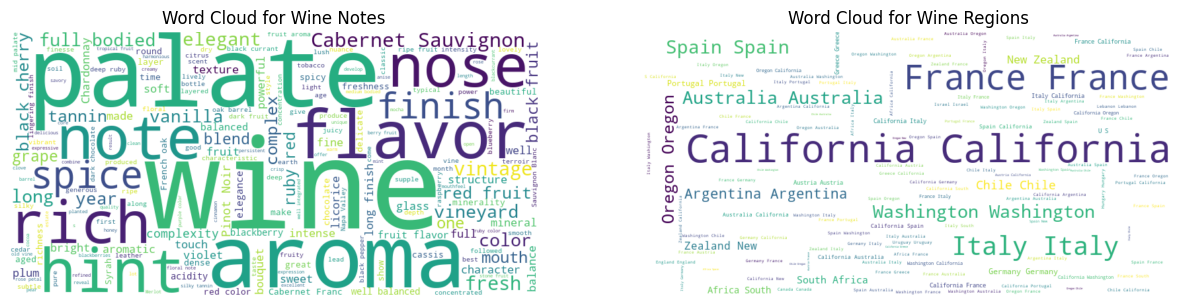

In [23]:
from wordcloud import WordCloud

notes_text = " ".join(notes for notes in wine_df["notes"].dropna())

# Combine all text in the 'region' column into a single string
region_text = " ".join(region for region in wine_df["country_state"].dropna())

# Create a word cloud for 'notes'
wordcloud_notes = WordCloud(width=800, height=400, background_color="white").generate(notes_text)

# Create a word cloud for 'country_state'
wordcloud_region = WordCloud(width=800, height=400, background_color="white").generate(region_text)

# Plot the word clouds
plt.figure(figsize=(15, 7))

# Word cloud for 'notes'
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_notes, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Wine Notes")

# Word cloud for 'region'
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_region, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Wine Regions")

plt.show()

### **Summary**
- **Wine Notes**: Words like "flavor", "aroma", "wine", and "palate" are prominent, indicating common themes in wine descriptions.
- **Wine Regions**: Regions like "California", "Spain", and "Chile" dominate, reflecting their prominence in the wine industry.

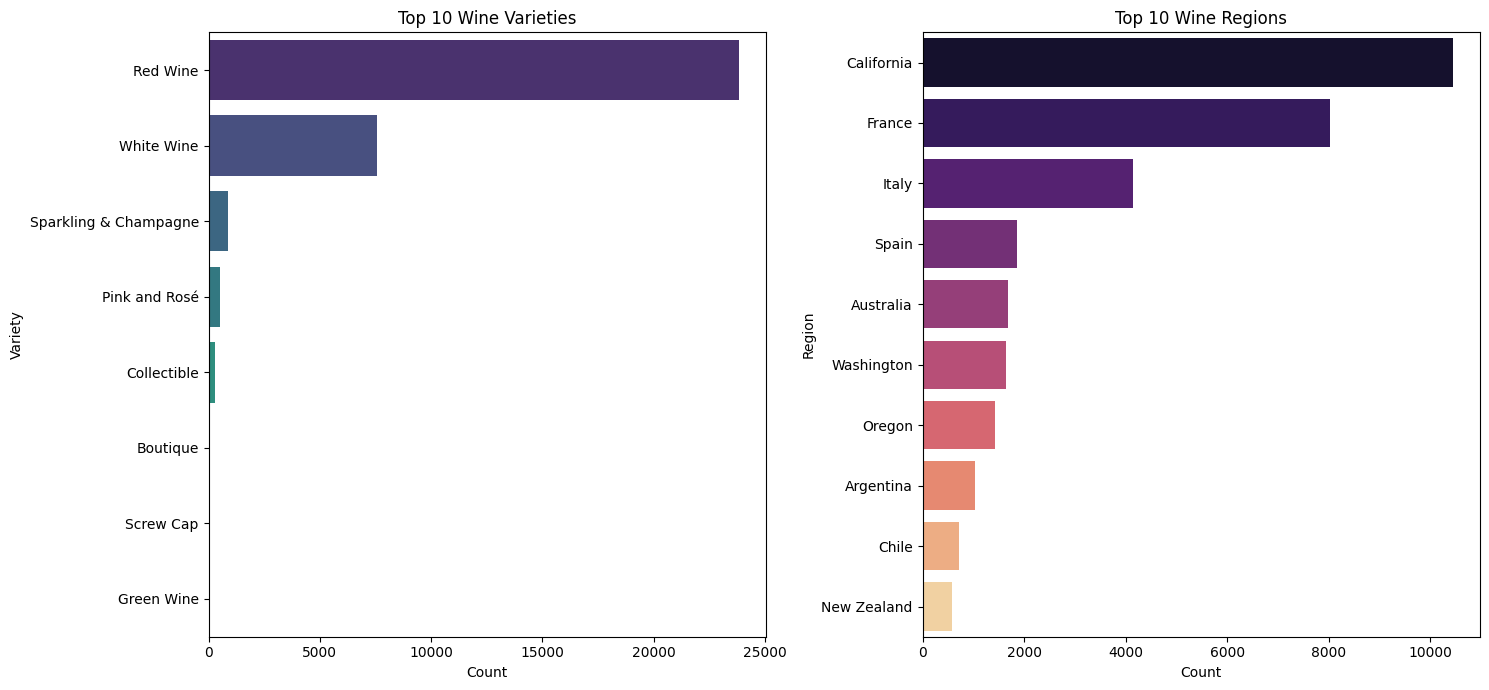

In [24]:
# Count the frequency of each variety
variety_counts = wine_df["variety"].value_counts().head(10)  # Top 10 varieties

# Count the frequency of each region
region_counts = wine_df["country_state"].value_counts().head(10)  # Top 10 regions

# Plot the top varieties
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(x=variety_counts.values, y=variety_counts.index, palette="viridis")
plt.title("Top 10 Wine Varieties")
plt.xlabel("Count")
plt.ylabel("Variety")

# Plot the top regions
plt.subplot(1, 2, 2)
sns.barplot(x=region_counts.values, y=region_counts.index, palette="magma")
plt.title("Top 10 Wine Regions")
plt.xlabel("Count")
plt.ylabel("Region")

plt.tight_layout()
plt.show()

### **Summary**
- **Wine Varieties**: "Red Wine" and "White Wine" are the most common varieties, followed by "Pink and Rose" and "Sparkling & Champagne".
- **Wine Regions**: "California" is the most frequent region, followed by "France" and "Italy". This highlights the importance of these regions in wine production.

### **12. Topic Modeling with Latent Dirichlet Allocation (LDA)**
In this section, we perform topic modeling on the `notes` column to identify common themes in wine descriptions. Topic modeling helps uncover hidden patterns in text data by grouping similar words into topics.

In [25]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Preprocess the text (basic cleaning)
def preprocess(text):
    if isinstance(text, str):
        return text.lower().replace(".", "").replace(",", "")
    return ""

wine_df["cleaned_notes"] = wine_df["notes"].apply(preprocess)

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(wine_df["cleaned_notes"].dropna())

# Apply LDA
num_topics = 5  # Number of topics to extract
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(doc_term_matrix)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10  # Number of top words to display per topic
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
wine wines years great red soil best la grape elegance
Topic 2:
wine vineyard fruit oak grapes vintage months french vines years
Topic 3:
cabernet sauvignon blend merlot wine vineyard franc valley syrah vintage
Topic 4:
wine fruit aromas palate flavors finish citrus fresh notes acidity
Topic 5:
wine red fruit black palate aromas tannins finish notes cherry


### **Identified Topics**
1. **Topic 1**: Focuses on wine quality and elegance, with words like "great", "best", and "elegance".
2. **Topic 2**: Centers around vineyard and production, with words like "vineyard", "fruit", and "vintage".
3. **Topic 3**: Highlights specific grape varieties and blends, such as "cabernet sauvignon", "merlot", and "syrah".
4. **Topic 4**: Describes sensory attributes, with words like "aromas", "flavors", and "acidity".
5. **Topic 5**: Focuses on red wine characteristics, with words like "red", "black", and "tannins".

### **Key Insights**
- The topics reveal common themes in wine descriptions, such as quality, production, grape varieties, sensory attributes, and red wine characteristics.
- These themes can help in understanding how wines are described and categorized.

### **13. Text Similarity and Wine Recommendations**
In this section, we use **cosine similarity** to find wines with similar descriptions based on their tasting notes. This approach helps in building a recommendation system that suggests wines with similar profiles.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(wine_df["cleaned_notes"].dropna())

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Example: Find similar wines for a specific wine (e.g., index 0)
wine_index = 0
similar_wines = list(enumerate(cosine_sim[wine_index]))
similar_wines = sorted(similar_wines, key=lambda x: x[1], reverse=True)[1:6]  # Top 5 similar wines

# Display similar wines
print(f"Wines similar to '{wine_df.loc[wine_index, 'name']}':")
for i, sim in similar_wines:
    print(f"- {wine_df.loc[i, 'name']} (Similarity: {sim:.2f})")

Wines similar to '1000 Stories Bourbon Barrel Aged Batch Blue Carignan 2016':
- 1000 Stories Bourbon Barrel Aged Zinfandel 2016 (Similarity: 0.28)
- Battle Creek Cellars Unconditional Pinot Noir 2011 (Similarity: 0.28)
- Domaine Lafage Tessellae Old Vines Carignan 2011 (Similarity: 0.27)
- Exopto Cellars Big Bang 2006 (Similarity: 0.22)
- Chateau d'Or et de Gueules Costieres de Nimes Rouge Les Cimels 2012 (Similarity: 0.21)


### **Key Insights**
- The cosine similarity scores indicate how closely the tasting notes of the recommended wines match the target wine.
- This method can be used to build a recommendation system for wine enthusiasts or retailers.

### **14. Clustering Wine Descriptions with K-Means**
In this section, we use **K-Means clustering** to group wines based on their tasting notes. This helps identify patterns and themes in wine descriptions, which can be useful for categorization and recommendation.

In [27]:
from sklearn.cluster import KMeans

# Number of clusters
num_clusters = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Add cluster labels to the dataset
wine_df["cluster"] = kmeans.labels_

# Display the distribution of clusters
print(wine_df["cluster"].value_counts())

# Display top words for each cluster
def get_top_words_cluster(cluster_idx, tfidf_matrix, vectorizer, top_n=10):
    cluster_data = tfidf_matrix[wine_df["cluster"] == cluster_idx]
    mean_tfidf = np.asarray(cluster_data.mean(axis=0)).ravel()
    top_indices = mean_tfidf.argsort()[-top_n:][::-1]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    return top_words

for cluster_idx in range(num_clusters):
    print(f"Cluster {cluster_idx + 1} Top Words:")
    print(get_top_words_cluster(cluster_idx, tfidf_matrix, tfidf_vectorizer))

cluster
1    13281
0     8409
4     5453
2     5087
3      947
Name: count, dtype: int64
Cluster 1 Top Words:
['black', 'cherry', 'dark', 'wine', 'tannins', 'fruit', 'flavors', 'finish', 'aromas', 'palate']
Cluster 2 Top Words:
['wine', 'vineyard', 'fruit', 'wines', 'years', 'vintage', 'blend', 'grapes', 'cabernet', 'vines']
Cluster 3 Top Words:
['red', 'color', 'ruby', 'intense', 'deep', 'notes', 'tannins', 'nose', 'aromas', 'palate']
Cluster 4 Top Words:
['cabernet', 'merlot', 'franc', 'blend', 'sauvignon', 'verdot', 'petit', '10', '20', '80']
Cluster 5 Top Words:
['citrus', 'aromas', 'fresh', 'lemon', 'flavors', 'palate', 'apple', 'white', 'fruit', 'wine']


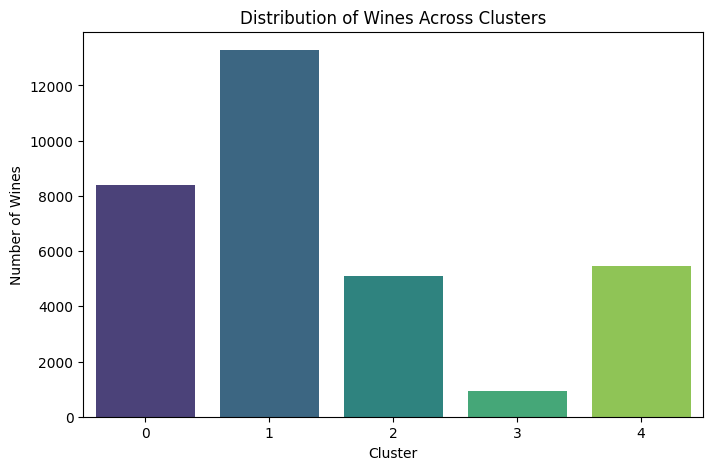

In [28]:
# Plot the distribution of clusters
plt.figure(figsize=(8, 5))
sns.countplot(x=wine_df["cluster"], palette="viridis")
plt.title("Distribution of Wines Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Wines")
plt.show()

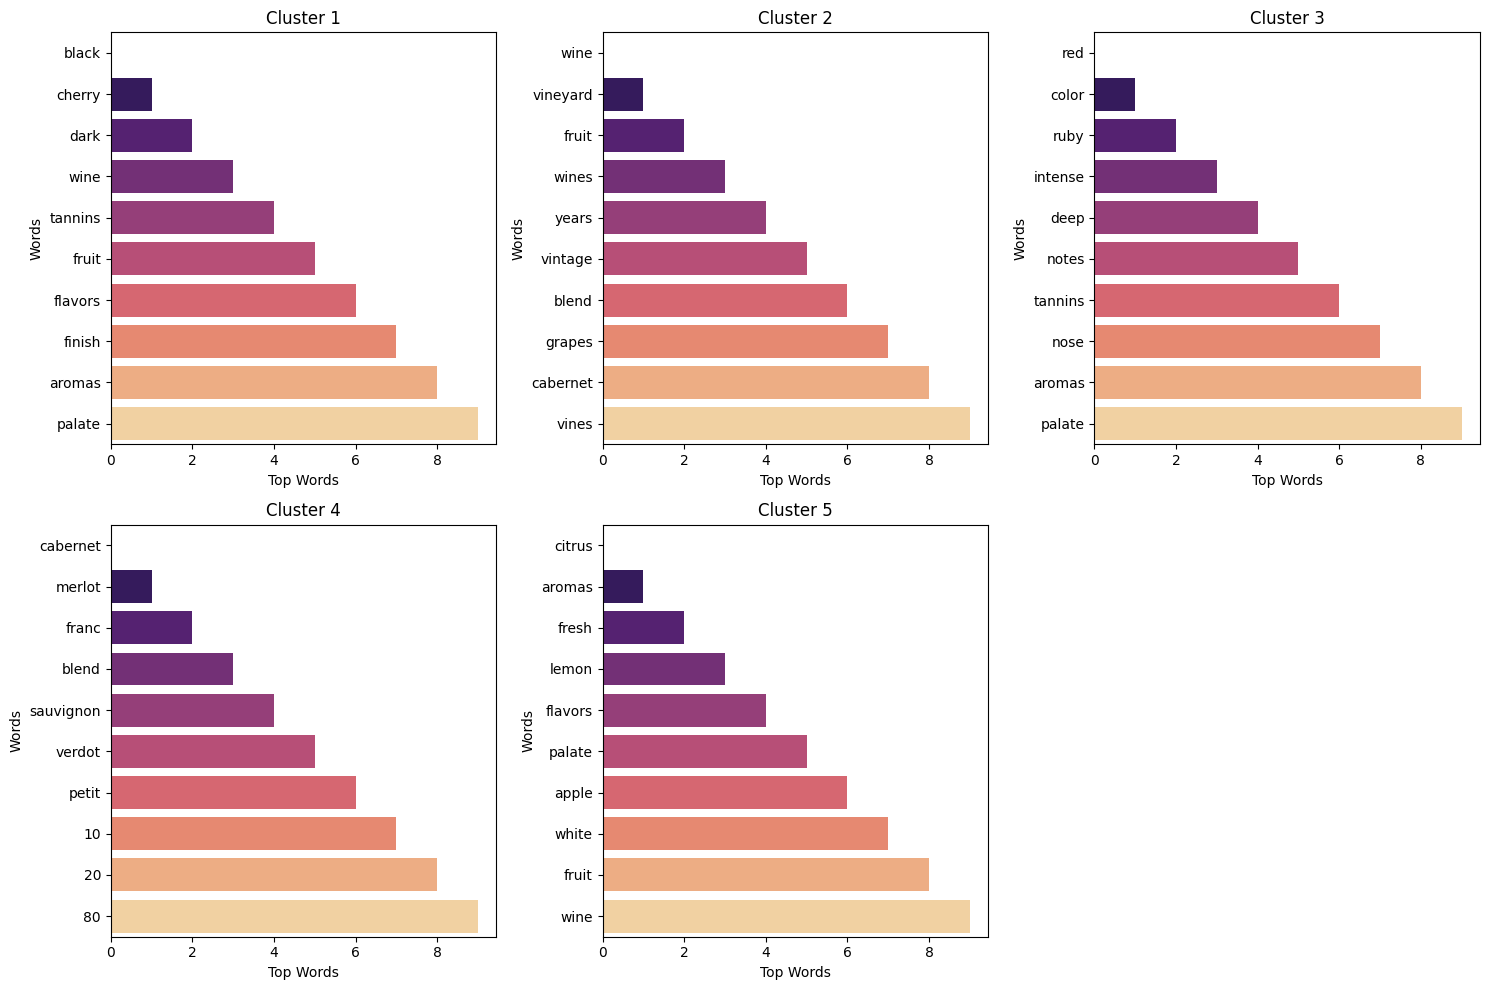

In [29]:
# Get top words for each cluster
top_words_per_cluster = {
    f"Cluster {i + 1}": get_top_words_cluster(i, tfidf_matrix, tfidf_vectorizer)
    for i in range(num_clusters)
}

# Plot top words for each cluster
plt.figure(figsize=(15, 10))
for i, (cluster, words) in enumerate(top_words_per_cluster.items()):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=np.arange(len(words)), y=words, palette="magma")
    plt.title(cluster)
    plt.xlabel("Top Words")
    plt.ylabel("Words")
plt.tight_layout()
plt.show()

### **Key Insights**
- **Cluster 1**: Focuses on dark fruit and tannins, likely representing full-bodied red wines.
- **Cluster 2**: Centers around vineyard and production terms, indicating a focus on winemaking processes.
- **Cluster 3**: Highlights red wine characteristics, such as color and intensity.
- **Cluster 4**: Emphasizes specific grape varieties and blends, like Cabernet and Merlot.
- **Cluster 5**: Describes fresh and citrusy flavors, likely representing white wines.

### **Visualizations**
- **Cluster Distribution**: A bar chart showing the number of wines in each cluster.
- **Top Words**: Bar charts displaying the top words for each cluster, helping interpret the themes.

### **15. Extracting Top Keywords from Wine Notes**
In this section, we extract the most important keywords from the `notes` column using **TF-IDF (Term Frequency-Inverse Document Frequency)**. This helps identify the most common and significant words used in wine descriptions.

Top 20 Keywords Across All Wines:
[('cabernet', 1464), ('zinfandel', 1412), ('evolve', 970), ('enjoyed', 967), ('evident', 900), ('red', 898), ('example', 871), ('blend', 853), ('merlot', 840), ('vineyard', 753), ('sauvignon', 692), ('black', 673), ('dark', 660), ('franc', 570), ('wine', 554), ('vintage', 483), ('pinot', 476), ('chardonnay', 469), ('fresh', 465), ('cherry', 442)]


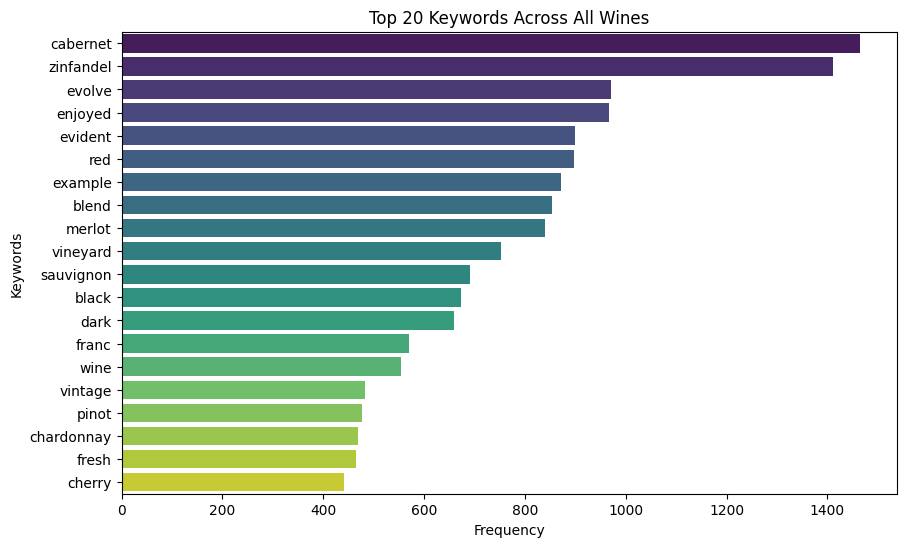

In [30]:
# Preprocess the text (basic cleaning)
def preprocess(text):
    if isinstance(text, str):
        return text.lower().replace(".", "").replace(",", "")
    return ""

wine_df["cleaned_notes"] = wine_df["notes"].apply(preprocess)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(wine_df["cleaned_notes"].dropna())

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Extract top keywords for each wine
def extract_top_keywords(tfidf_matrix, feature_names, top_n=5):
    top_keywords = []
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = row.argsort()[-top_n:][::-1]
        top_keywords.append([feature_names[idx] for idx in top_indices])
    return top_keywords

# Add top keywords to the dataset
wine_df["top_keywords"] = extract_top_keywords(tfidf_matrix, feature_names)

# Flatten the list of top keywords and count their frequency
from collections import Counter
all_keywords = [keyword for sublist in wine_df["top_keywords"] for keyword in sublist]
keyword_freq = Counter(all_keywords)

# Get the top 20 most common keywords
top_keywords_global = keyword_freq.most_common(20)
print("Top 20 Keywords Across All Wines:")
print(top_keywords_global)

# Prepare data for plotting
keywords, frequencies = zip(*top_keywords_global)

# Plot the top keywords
plt.figure(figsize=(10, 6))
sns.barplot(x=list(frequencies), y=list(keywords), palette="viridis")
plt.title("Top 20 Keywords Across All Wines")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.show()

### **Key Insights**
- **Grape Varieties**: Words like "cabernet", "zinfandel", "merlot", and "chardonnay" are prominent, reflecting the focus on specific grape varieties.
- **Descriptive Terms**: Words like "black", "dark", "red", and "fresh" describe the characteristics of the wines.
- **Wine Production**: Terms like "vineyard", "vintage", and "blend" highlight aspects of winemaking and production.

### **Visualization**
- A horizontal bar chart showing the frequency of the top 20 keywords, with "cabernet" being the most frequent.

### **16. Building a Wine Recommendation System**
In this section, we build a recommendation system that suggests wines based on the similarity of their tasting notes. This system uses **cosine similarity** to compare wine descriptions and recommend wines with similar profiles.

In [31]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(wine_df["cleaned_notes"].dropna())

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get recommendations
def get_recommendations(wine_name, cosine_sim=cosine_sim, top_n=5):
    idx = wine_df[wine_df["name"] == wine_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    wine_indices = [i[0] for i in sim_scores]
    return wine_df.iloc[wine_indices]



In [32]:
# Example: Get recommendations for a specific wine
recommended_wines = get_recommendations("Abreu Vineyards Las Posadas Howell Mountain 2012")
(recommended_wines[["name", "region", "variety", "rating"]].head())

name  \
219     Abreu Vineyards Howell Mountain 2008   
31058    La Vizcaina La Vitoriana Tinto 2013   
22899        Folin Cellars Petite Sirah 2011   
11513                 Chateau Jean Faux 2009   
29051  K Vintners Art Den Hoed Viognier 2013   

                                           region     variety  rating  
219      Howell Mountain, Napa Valley, California    Red Wine    96.0  
31058                               Bierzo, Spain    Red Wine    93.0  
22899                        Rogue Valley, Oregon    Red Wine    90.0  
11513                            Bordeaux, France    Red Wine    91.0  
29051  Yakima Valley, Columbia Valley, Washington  White Wine    90.0

In [36]:
wine_df.to_csv('wine_df.csv', index=False)

### **Key Insights**
- The recommendation system successfully identifies wines with similar tasting notes, even across different regions and varieties.
- The system can be used to suggest wines to customers based on their preferences or previous purchases.

This exploratory data analysis (EDA) focused on understanding the structure, patterns, and insights within a dataset of wine ratings and descriptions. The analysis covered several key areas:

1. **Data Preprocessing**:
   - Handled missing values in the `variety` column using a RandomForestClassifier.
   - Cleaned and preprocessed text data (e.g., `notes` column) for analysis.

2. **Distribution of Wine Ratings**:
   - Most wines have ratings between **85 and 95**, with fewer wines at the extremes.
   - The distribution is slightly left-skewed, indicating a concentration of high-quality wines.

3. **Popular Wine Varieties and Regions**:
   - **Red Wine** and **White Wine** are the most common varieties.
   - **California**, **France**, and **Italy** are the most frequent wine regions.

4. **Text Analysis**:
   - **Word Clouds**: Highlighted common words in wine descriptions (e.g., "aroma", "fruit", "tannins") and regions (e.g., "California", "France").
   - **Topic Modeling**: Identified 5 key topics in wine descriptions, such as "vineyard and production" and "red wine characteristics".
   - **Keyword Extraction**: Extracted the top 20 keywords across all wines, including "cabernet", "zinfandel", and "merlot".

5. **Temporal Analysis**:
   - The number of wine samples increases significantly over time, especially after the year 2000.
   - Wine ratings remain stable over time, with no significant upward or downward trend.

6. **Clustering**:
   - Wines were grouped into 5 clusters based on their tasting notes, revealing themes like "dark fruit and tannins" and "fresh and citrusy flavors".

7. **Recommendation System**:
   - Built a recommendation system using cosine similarity to suggest wines with similar tasting notes.
   - Example: For "Abreu Vineyards Las Posadas Howell Mountain 2012", the system recommended wines like "Abreu Vineyards Howell Mountain 2008" and "La Vizcaina La Vitoriana Tinto 2013".

### **Key Insights**
- The dataset is rich in high-quality wines, with most ratings concentrated between 85 and 95.
- **Red Wine** and **White Wine** dominate the dataset, with **California** being the most prominent wine region.
- Common themes in wine descriptions include vineyard production, grape varieties, and sensory attributes.
- The recommendation system effectively identifies wines with similar profiles, making it useful for wine enthusiasts or retailers.

### **Next Steps**
- Further refine the recommendation system by incorporating additional features like region, variety, and price.
- Explore deeper insights into emerging trends, such as organic or sustainable wines.
- Build predictive models to estimate wine ratings based on descriptions and metadata.